# Detecting Eye color

From Lesson 2 Fast.ai

Trying to detect green/blue/brown eye colors using Google images as trainning
Read carefully, this notebook is not meant to run at once, rather it loops. First it trains on the folders, then we clean and then we come back uo to make a new ImageBunch from the `cleaned.csv` to train again, and then clean again, till we are happy.

In [7]:
from fastai.vision import *

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "green eyes face"

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise window.open() coomand doesn't work. Then you can run the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [1]:
folder = 'blue'
file = 'blue.csv'

In [2]:
folder = 'green'
file = 'green.csv'

In [3]:
folder = 'brown'
file = 'brown.csv'

You will need to run this cell once per each category.

In [8]:
path = Path('data/eyes')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [9]:
path.ls()

[PosixPath('data/eyes/blue.csv'),
 PosixPath('data/eyes/brown'),
 PosixPath('data/eyes/models'),
 PosixPath('data/eyes/brown2.csv'),
 PosixPath('data/eyes/brown.csv'),
 PosixPath('data/eyes/green.csv'),
 PosixPath('data/eyes/blue2.csv'),
 PosixPath('data/eyes/cleaned.csv'),
 PosixPath('data/eyes/green2.csv'),
 PosixPath('data/eyes/green'),
 PosixPath('data/eyes/blue')]

Finally, upload your urls file. You just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.

![uploaded file](images/download_images/upload.png)

## Download images

Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [5]:
classes = ['brown','blue','green']

In [50]:
print(path,file,dest)
download_images(path/file, dest, max_pics=200)

In [ ]:
# If you have problems download, try with `max_workers=0` to see exceptions:
download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [10]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [95]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [52]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [53]:
data.classes

['blue', 'brown', 'green']

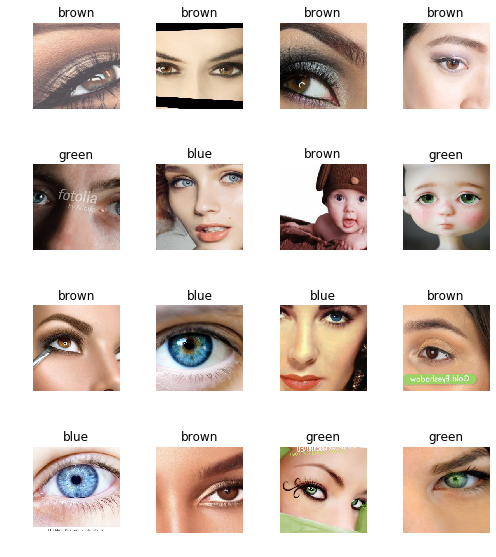

In [54]:
data.show_batch(rows=4, figsize=(7,8))

In [55]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['blue', 'brown', 'green'], 3, 316, 78)

## Train model

In [56]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [57]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.516234,1.052008,0.576923,00:05
1,1.208564,0.776255,0.346154,00:04
2,0.983059,0.856194,0.307692,00:04
3,0.829208,0.897746,0.333333,00:04
4,0.732112,0.926596,0.333333,00:04
5,0.665090,0.933683,0.333333,00:04
6,0.619604,0.929136,0.320513,00:04
7,0.572542,0.920162,0.294872,00:04


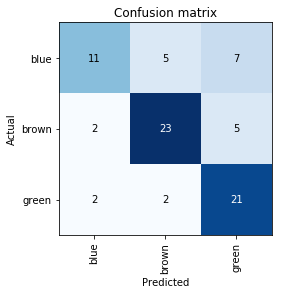

In [58]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

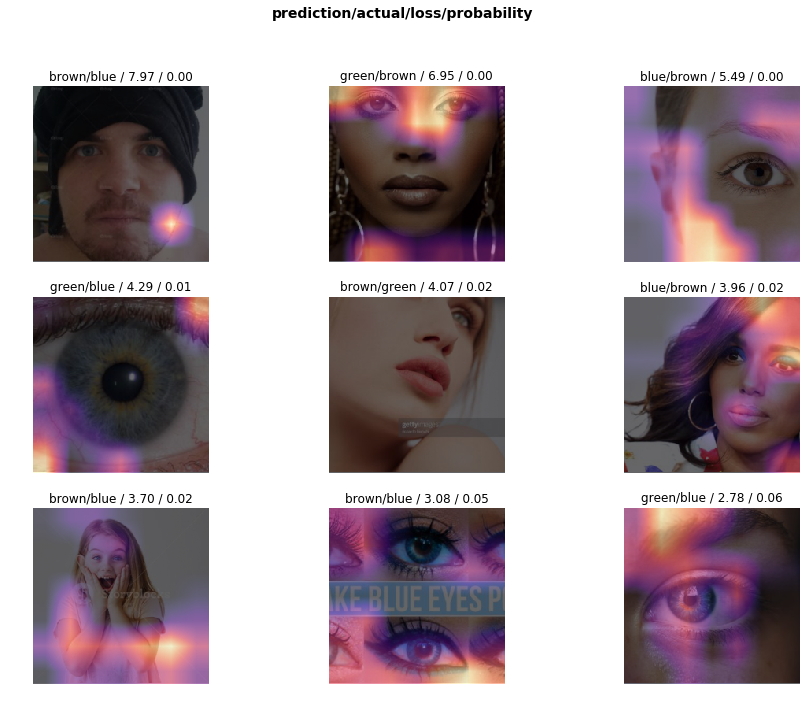

In [59]:
interp.plot_top_losses(9, figsize=(15,11))


In [60]:
learn.save('stage-1')

In [61]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


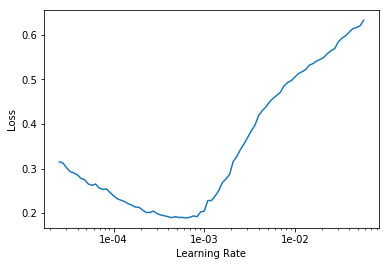

In [62]:
learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(20, max_lr=slice(3e-4,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.377080,0.883762,0.282051,00:05
1,0.351975,1.203770,0.294872,00:05
2,0.356792,1.389156,0.282051,00:05
3,0.374584,1.575372,0.307692,00:05
4,0.363433,2.373180,0.256410,00:05
5,0.366003,3.250920,0.243590,00:05
6,0.363002,3.703566,0.320513,00:05
7,0.355426,3.437111,0.410256,00:05
8,0.348408,1.689216,0.243590,00:05
9,0.331999,1.125706,0.243590,00:05


In [69]:
learn.save('stage-2')

## Interpretation

In [70]:
learn.load('stage-2');

In [71]:
interp = ClassificationInterpretation.from_learner(learn)

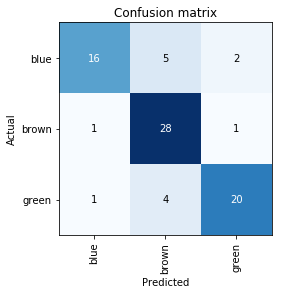

In [72]:
interp.plot_confusion_matrix()

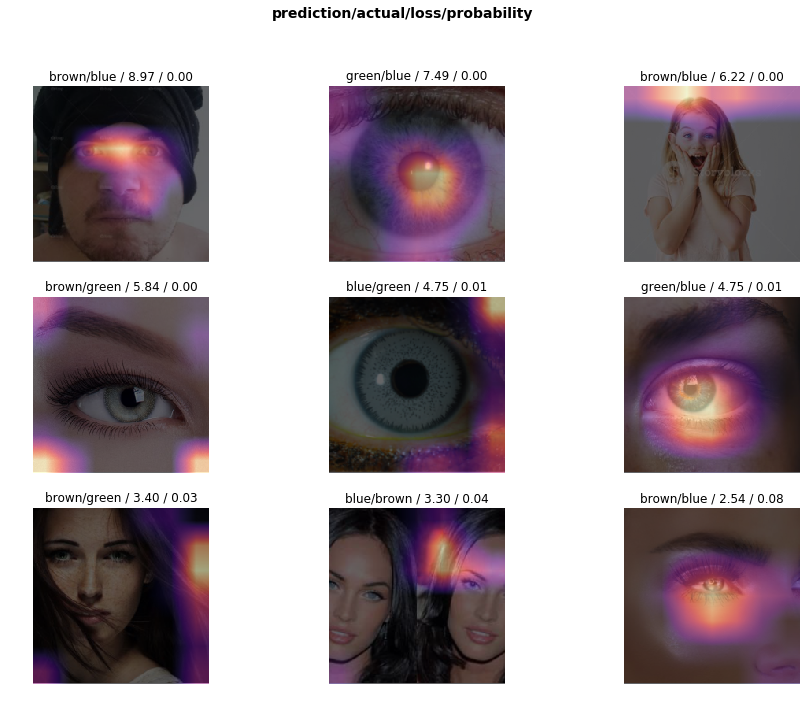

In [73]:
interp.plot_top_losses(9, figsize=(15,11))


## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [26]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the `ds_type` param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [82]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [74]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .no_split()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:180: UserWarning: `no_split` is deprecated, please use `split_none`.
  warn("`no_split` is deprecated, please use `split_none`.")


Then we create a new learner to use our new databunch with all the images.

In [76]:
learn_cln = cnn_learner(db, models.resnet50, metrics=error_rate)

learn_cln.load('stage-2');

In [77]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [78]:
# Don't run this in google colab or any other instances running jupyter lab.# If you do run this on Jupyter Lab, you need to restart your runtime and# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, loosing all the results from cleaning the data from toplosses.

In [31]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [35]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

Redo de learning after cleaning the ones with the biggest losses

In [ ]:
data = ImageDataBunch.from_csv(path,csv_labels='cleaned.csv', valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [79]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [80]:
defaults.device = torch.device('cpu')

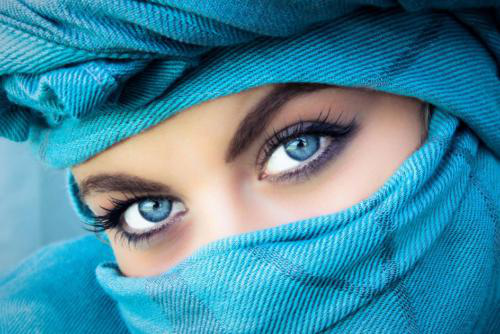

In [83]:
img = open_image(path/'blue'/'00000039.jpg')
img

We create our `Learner` in production enviromnent like this, jsut make sure that `path` contains the file 'export.pkl' from before.

In [84]:
learn = load_learner(path)

In [85]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category blue



```python
from starlette.applications import Starlette
from starlette.responses import JSONResponse,HTMLResponse
import uvicorn
from fastai.vision import *
from fastai import *
import torch
from pathlib import Path
from io import BytesIO
import sys
import aiohttp
import asyncio

app = Starlette(debug=True)

path = Path("data")
learn = load_learner(path)
classes = ['blue','brown','green']


@app.route("/")
def form(request):
    return HTMLResponse("""
        <h3>This app will classify eye color <h3>

        <form action="/upload" method="post" enctype="multipart/form-data">
            Select image to upload:
            <input type="file" name="file">
            <input type="submit" value="Upload Image">
        </form>

        Or submit a URL:

        <form action="/classify-url" method="get">
            <input type="url" name="url">
            <input type="submit" value="Fetch and analyze image">
        </form>
    """)

@app.route("/upload", methods=["POST"])
async def upload(request):
    data = await request.form()
    bytes = await (data["file"].read())
    return predict_image_from_bytes(bytes)

@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    return predict_image_from_bytes(bytes)

async def get_bytes(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            return await response.read()

def predict_image_from_bytes(bytes):
    img = open_image(BytesIO(bytes))
    _, class_, losses = learn.predict(img)
    return JSONResponse({
        "prediction": classes[class_.item()],
        "scores": sorted(
            zip(learn.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })

if __name__ == '__main__':
    uvicorn.run(app, host='0.0.0.0', port=8000)

```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)